In [1]:
import pandas as pd
import sys
sys.path
sys.path.append('../models')
import numpy as np
import pickle
import random
import os
import math
import sim_functions_cleaner  as sf
import operator
import study
import time as time_module

import TS_personal_params_pooled as pp
import TS_global_params_pooled as gtp
from numpy.random import uniform

#sys.path.append('../simulation')
import TS_fancy_pooled 
import TS
#import TS_fancy_pooled 
import eta
import pooling_bandits as pb
import warnings 
warnings.simplefilter('ignore')
from sklearn import preprocessing
import tensorflow as tf
import gc
import feature_transformations as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pympler import muppy
all_objects = muppy.get_objects()
from pympler import summary


In [3]:
##for each person generate dates
##easiest to take from original data, this might best mimic actual situation 

In [4]:
#root =  '../../../../Volumes/dav/HeartSteps/pooling_rl_shared_data/processed/'

In [5]:
write_directory = '../temp'

In [6]:
def initialize_policy_params_TS(experiment,update_period,standardize=False):
    #,'location_1','location_2','location_3'
    #'continuous_temp',
    global_p =gtp.TS_global_params(21,baseline_keys=['pretreatment','weather','dow','tod','location'],psi_features=[0,6], responsivity_keys= ['pretreatment','weather','dow','tod','location'])
    personal_p = pp.TS_personal_params()
    #global_p =gtp.TS_global_params(10,context_dimension)
    
    
    
    #global_p.mu_dimension = 64

    global_p.kdim =24
    #194
    global_p.baseline_indices = [i for i in range(24)]
    #[i for i in range(192)]
    #[0,1,2,3,4,5,6]
    global_p.psi_indices =[0,6]
    #[0,64]
    global_p.user_id_index =21
 
    global_p.psi_features =[0,6]
    #[0,64]
    
    global_p.update_period = update_period
    
    global_p.standardize = standardize
    #print(type(personal_p))
    
    for person in experiment.population.keys():
        experiment.population[person].root = '../../regal/murphy_lab/pooling/distributions/'
        initial_context = [0 for i in range(global_p.theta_dim)]
        personal_p.mus0[person]= global_p.get_mu0(initial_context)
        personal_p.mus1[person]= global_p.get_mu1(global_p.num_baseline_features)
        personal_p.mus2[person]= global_p.get_mu2(global_p.num_responsivity_features)
        
        personal_p.sigmas0[person]= global_p.get_asigma(len( personal_p.mus0[person]))
        personal_p.sigmas1[person]= global_p.get_asigma(global_p.num_baseline_features+1)
        personal_p.sigmas2[person]= global_p.get_asigma( global_p.num_responsivity_features+1)
        
        
        
        personal_p.batch[person]=[[] for i in range(len(experiment.person_to_time[person]))]
        personal_p.batch_index[person]=0
        
        #personal_p.etas[person]=eta.eta()
        
        personal_p.last_update[person]=experiment.person_to_time[person][0]
        
        
    return global_p ,personal_p     

In [7]:
def get_optimal_reward(beta,states):
    return np.dot(beta,states)

In [52]:
def new_kind_of_simulation(experiment,policy=None,personal_policy_params=None,global_policy_params=None,which_gen=None,tf = None):
    #write_directory = '../../murphy_lab/lab/pooling/temp'
    experiment.last_update_day=experiment.study_days[0]
    for time in experiment.study_days:
        
        #if time> experiment.study_days[0]:
        #history  = pb.make_history(experiment)
        if time==experiment.last_update_day+pd.DateOffset(days=global_policy_params.update_period):
            experiment.last_update_day=time
            #print('Global update', time,global_policy_params.decision_times, file=open('updates_{}_{}.txt'.format(len(experiment.population),global_policy_params.update_period), 'a'))
            if global_policy_params.decision_times>2:
                global_policy_params.last_global_update_time=time
              
        tod = sf.get_time_of_day(time)
        dow = sf.get_day_of_week(time)
        if time==experiment.study_days[0]:
            print('init weather')
            weather = tf.get_weather_prior(tod,time.month)
            temperature = tf.continuous_temperature(weather)
        elif time.hour in experiment.weather_update_hours and time.minute==0:
            weather = tf.get_next_weather(str(tod),str(time.month),weather)
            temperature = tf.continuous_temperature(weather)
            ##location depends on person 
            
        for person in experiment.dates_to_people[time]:
                dt=False
                action = 0 
                prob=0
                #1
                ##for every active person update person specific aspects of their context
                participant = experiment.population[person]
                if time==participant.last_update_day+pd.DateOffset(days=global_policy_params.update_period):
                    
                    history = participant.history
                    
                    #print(participant.pid)
                    #print('updated')
                    #print(participant.last_update_day)
                    #print(history)
                    #return {participant.pid:history}
                    temp_hist = tf.get_history_decision_time_avail_single({participant.pid:history},time)
                    
                    temp_hist= tf.history_semi_continuous(temp_hist,global_policy_params)
                    #sf.get_data_for_txt_effect_u
                    
                    context,steps,probs,actions= tf.get_form_TS(temp_hist)
                    #sf.get_data_for_txt_effect_update(history,global_policy_params)
                       
                    #phi = get_phi(context,probs,actions,[i for i in range(len(context[0]))],[i for i in range(len(context[0]))])
                    
                    temp = TS.policy_update_ts_new( context,steps,probs,actions,global_policy_params.sigma,\
                                               personal_policy_params.mus1[participant.pid],\
                                               personal_policy_params.sigmas1[participant.pid],\
                                               personal_policy_params.mus2[participant.pid],\
                                               personal_policy_params.sigmas2[participant.pid],
                                                
                                              )
                    mu_beta = temp[0]
                    Sigma_beta = temp[1]
                    personal_policy_params.update_mus(participant.pid,mu_beta,2)
                    personal_policy_params.update_sigmas(participant.pid,Sigma_beta,2)
                    participant.last_update_day=time
                    history = None
    
                #update global context variables
                participant.set_tod(tod)
                participant.set_dow(dow)
                participant.set_wea(weather)
                
                
                availability = (uniform() < 0.8)
                participant.set_available(availability)
                
                if time == participant.times[0]:
                    #get first location 
                    location = tf.get_location_prior(str(participant.gid),str(tod),str(dow))
                    participant.set_inaction_duration(0)
                    participant.set_action_duration(0)
                   
                    
                    
                if time <= participant.times[0]:
                    steps_last_time_period = 0  
                    
                    ##set first pre-treatment, yesterday step count, variation and dosage
                else:
                    
                    if time.hour==0 and time.minute==0:
                        participant.current_day_counter=participant.current_day_counter+1
                    
                    #print(time)
                    steps_last_time_period = participant.steps
                
                 

                if time.hour in experiment.location_update_hours:
                    location = tf.get_next_location(participant.gid,tod,dow,participant.get_loc())
                
    
                
                participant.set_loc(location)
                

                prob = -1
                add=None
                optimal_action = -1
                optimal_reward = -100
                if time in participant.decision_times:
                                        #print(personal_policy_params.batch_index[participant.pid])
                    
                    
                    ##if we have made no global updates

                    
                    
                    
                    dt=True
                    action=0
                    
                    

                    
                    if policy==None:
                        action = sf.get_action(policy)
                        
                        
                        
                    elif policy=='TS':
                 
                        #,int(location==1),int(location==2),int(location==3)
                    #temperature,
                    #sf.get_pretreatment()
                        z=np.array([1,tod,dow,weather,sf.get_pretreatment(participant.steps),location])
                        
                        
                        prob = TS.prob_cal_ts(z,0,personal_policy_params.mus2[participant.pid],personal_policy_params.sigmas2[participant.pid],global_policy_params)
                        
                        #print('prob {}'.format(prob))
                        
                        action = int(uniform() < prob)
                            

                    
                        if availability:
                    

                   
                    
                    
                   
                    
                            context = [action,participant.gid,tod,dow,weather,sf.get_pretreatment(participant.steps),location,\
                0,0,0]
                    
                        
                            steps = tf.get_steps_action(context)
                        
                        
                            add = sf.get_add_two(action,z,experiment.beta,participant.Z)
                   
                        
                            participant.steps = steps+add
                        
                            optimal_reward = get_optimal_reward(experiment.beta,z)
                            optimal_action = int(optimal_reward>=0)
                        
                    else:
                   
                        steps = tf.get_steps_no_action(participant.gid,tod,dow,location,weather,sf.get_pretreatment(steps_last_time_period))
                        participant.steps = steps

                

                    global_policy_params.decision_times =   global_policy_params.decision_times+1
                
                    
                    
                else:
                    #participant.steps_last_time_period = participant.steps
                        steps = tf.get_steps_no_action(participant.gid,tod,dow,location,weather,sf.get_pretreatment(steps_last_time_period))
                        participant.steps = steps     
                
                ##history:
              
                 ##history:
                context_dict =  {'steps':participant.steps,'add':add,'action':action,'weather':weather,'location':location,'location_1':int(location==1),\
                    'ltps':steps_last_time_period,'location_2':int(location==2),'location_3':int(location==3),\
                        'study_day':participant.current_day_counter,\
                                 'temperature':temperature,'decision_time':dt,\
                                 'time':time,'avail':availability,'prob':prob,\
                                 'dow':dow,'tod':tod,\
                                 'pretreatment':sf.get_pretreatment(steps_last_time_period),\
                                'optimal_reward':optimal_reward,'optimal_action':optimal_action}
                participant.history[time]=context_dict


                #if global_policy_params.decision_times%100==0:
                   # my_directory = '{}/pop_size_{}_update_{}_study_length_{}/participant_{}'.format(global_policy_params.write_directory,participant.pid,experiment.study_length,len(experiment.population),global_policy_params.update_period)
                    #if not os.path.exists(my_directory):
                     #   os.makedirs(my_directory)
                    #with open('{}/history_{}.pkl'.format(my_directory,global_policy_params.decision_times),'wb') as f:
                     #   pickle.dump(participant.history,f)




In [53]:
def make_to_save(exp):
    to_save  = {}
    for pid,pdata in exp.population.items():
        for time,context in pdata.history.items():
            key = '{}-{}-{}'.format(pid,time,pdata.gid)
            to_save[key]=context
    return to_save

In [54]:
pop_size=32
experiment = study.study('../../Downloads/distributions/',pop_size,'short','case_one')

In [55]:
glob,personal = initialize_policy_params_TS(experiment,1,standardize=False)

18


In [56]:
feat_trans = tf.feature_transformation('../../Downloads/distributions/')

In [57]:
glob.sigma

1.0

In [58]:
start = time_module.time()
hist = new_kind_of_simulation(experiment,'TS',personal,glob,tf=feat_trans)
end = time_module.time()
print(end-start)

init weather
33.84421682357788


In [64]:
personal.mus2[11]

array([-0.86251789, -0.02010749,  1.27925312,  0.66849518, -0.09534641,
       -0.38040051])

In [60]:
experiment.beta


array([ 0.0977,  0.0858,  0.111 ,  0.181 , -0.217 ,  0.255 ])

In [61]:
all_steps  = []
for p in experiment.population.values():
    all_steps.extend([v['add'] for v in p.history.values() if v['action'] and v['decision_time'] and v['add'] is not None])
np.array(all_steps).mean()

0.2831439800374298

In [62]:
all_steps  = []
for p in experiment.population.values():
    all_steps.extend([v['steps'] for v in p.history.values() if v['action'] and v['decision_time']])
np.array(all_steps).mean()

5.30929106860927

In [19]:
def get_regret(experiment):
    optimal_actions ={}
    rewards = {}
    
    for pid,person in experiment.population.items():
        for time,data in person.history.items():
            if data['decision_time'] and data['avail']:
                key = time
                if key not in optimal_actions:
                    optimal_actions[key]=[]
                if key not in rewards:
                    rewards[key]=[]
                if data['optimal_action']!=-1:
                    optimal_actions[key].append(int(data['action']==data['optimal_action']))
                    regret = int(data['action']!=data['optimal_action'])*(abs(data['optimal_reward']-data['steps']))
                    rewards[key].append(regret)
    return optimal_actions,rewards

In [48]:
actions,regets = get_regret(experiment)

In [49]:
def get_to_plot_actions(actions):
    
    skeys = sorted(actions.keys())
    to_plot = []
    for k in skeys:
        to_plot.append(sum(actions[k])/len(actions[k]))
    return to_plot

In [50]:
aplot =  get_to_plot_actions(actions)

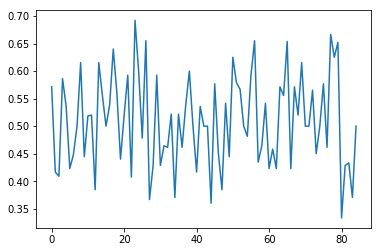

In [51]:
plt.plot([aplot[i] for i in range(0,len(aplot),5)])

In [65]:
def run_many():
    #for case in ['case_one']:
    case = 'case_one'
    for u in [1,7]:
        
        all_actions = {}
        all_rewards = {}
        feat_trans = tf.feature_transformation('../../Downloads/distributions/')
        
        for sim in range(50):
            pop_size=32
            experiment = study.study('../../Downloads/distributions/',pop_size,'short',which_gen=case)
            glob,personal = initialize_policy_params_TS(experiment,u,standardize=False)
            hist = new_kind_of_simulation(experiment,'TS',personal,glob,tf=feat_trans)
            to_Save = make_to_save(experiment)
            actions,rewards = get_regret(experiment)
            
            for i,a in actions.items():
                if i not in all_actions:
                    all_actions[i]=a
                else:
                    all_actions[i].extend(a)
            for i,a in rewards.items():
                if i not in all_rewards:
                    all_rewards[i]=a
                else:
                    all_rewards[i].extend(a)
            

            filename = '{}/results/{}/population_size_{}_update_days_{}_{}_static_sim_{}_indi_coeff.pkl'.format('../../Downloads/pooling_results/personalized/',case,pop_size,u,'short',sim)
            with open(filename,'wb') as f:
                pickle.dump(to_Save,f)
        filename = '{}/results/{}/population_size_{}_update_days_{}_{}_static_sim_regrets_actions_l_indi_coeff.pkl'.format('../../Downloads/pooling_results/personalized/',case,pop_size,u,'short')
        with open(filename,'wb') as f:
            pickle.dump({'actions':all_actions,'regrets':all_rewards},f)

In [ ]:
run_many()

18
init weather


In [40]:
to_Save = make_to_save(experiment)

In [41]:
    filename = '{}/results/population_size_{}_update_days_{}_{}_static.pkl'.format('../../Downloads/pooling_results/personalized/',pop_size,7,'short')
    with open(filename,'wb') as f:
        pickle.dump(to_Save,f)

In [47]:
goods = []
bads = []
for participant in experiment.population:
    if personal.mus2[participant][0]>0 and personal.mus2[participant][1]>0:
        goods.append(participant)
    else:
        bads.append(participant)
print(len(goods))
print(len(bads))
print(len(goods)/(len(goods)+len(bads)))


0
32
0.0


##### all_steps  = [
]
for p in experiment.population.values():
    all_steps.extend([v['steps'] for v in p.history.values()])

In [72]:
#o
20.15853214263916
0.16741123356661955
247.8333568572998
#faster

#with more data
159
0.0390877393575815

0

In [34]:
xz = np.ones((23,23))

In [36]:
y = np.array([np.array([1]+[i for i in row]) for row in xz]).mean()

In [37]:
y

1.0

In [53]:
g = get_history(write_directory,1)

In [11]:
def create_phi_new(history_dict,pi,global_params):
    #these things will be accessed by the global params
    indices = ['weather','location']
    g0 = ['location']
    f1=['ltps']
    
    ##returns phi and psi indices
    ##this could be a bit faster not appending all the time
    all_data = []
    steps=[]
    for user_id,history in history_dict.items():
        #history = d.history
        #history_keys = sorted(history)
        for hk,h in history.items():
            
            h = history[hk]
            if h['decision_time']:
                v = [1]
                v.extend([h[i] for i in indices])
                v.append(pi*1)
                v.extend([pi*h[i] for i in f1])
                action = h['action']
                if action<0:
                    action=0
                
                v.append((action-pi)*1)
                v.extend([(action-pi)*h[i] for i in f1])
                v.append(action)
                v.append(float(user_id))
                v.append(float(h['study_day']))
                all_data.append(v)
                steps.append(h['steps'])
    return all_data,steps

In [55]:
p = create_phi_new(g,.6,glob)

In [12]:
def make_history_new(write_directory,pi,glob):
    g = get_history(write_directory,glob.decision_times)
    ad = create_phi_new(g,pi,glob)
    if len(ad[0])==0:
        return [[],[]]
    
    new_x = preprocessing.scale(np.array(ad[0]))
    new_y = preprocessing.scale(np.array(ad[1]))
    y = np.array([[float(r)] for r in new_y])
    X = new_x
    return [X,y]

In [49]:
np.array(gr[0][0]).mean()

446.51003316358634

In [7]:
np.array(means).mean()

137.29867338336618

In [38]:
gr[1][0]

[2, 0, 0, 0, 2, 1, 0, 1, 1]

In [13]:
get_today_variance(gr[0],gr[1],gr[2])

False


0.0

In [14]:
def get_all_day_slices(first,last):
    slices = []
    day = first
    
    while day<last:
        slice_one = [day]
        #slice_one.append(day.replace(hour=23,minute=30))
        
        day_two = day+pd.DateOffset(days=1)
        slice_one.append(day_two)
        slices.append(slice_one)
        day=day_two
    return slices

In [8]:
def transform_to_hour(steps):
    to_return = []
    for i in range(0,len(steps)-1,2):
        to_return.append(steps[i]+steps[i+1])
    return to_return

In [35]:
def day_slices_to_median(day_slices,day_lookup,all_steps):
    days_steps = []
    for ds in day_slices:
        steps = all_steps[day_lookup[ds[0]]:day_lookup[ds[1]]]
       
        steps = transform_to_hour(steps)
        print(len(steps))
        days_steps.append(np.array(steps).std())

    return np.median(np.array(days_steps))
        

In [19]:
x=get_all_day_slices(gr[3],gr[4])

In [43]:
gr[4]

Timestamp('2015-07-29 00:00:00', freq='30T')

In [13]:
[1]+[2]+[3,4]

[1, 2, 3, 4]

In [3]:
    last_index = dd[one_week_ago.date()][0]
    
    day_slices=get_all_day_slices(last_index,dd[i.date()][0])
    
    median = day_slices_to_median(day_slices,gr[2],gr[5])

You can pass in a bunch of decision times. I just tested with one. 

Right now I think the number of people is being totally ignored. This needs to be fixed. 

In [12]:
x=sim_functions.simulate_run(num_people,temp_indices,decision_times)

NameError: name 'temp_indices' is not defined

In [14]:
np.array(x).mean()
#np.array(x).std()

207.01370855122792

In [15]:
np.array(x).mean()
np.array(x).std()

267.8619020654599

In [ ]:
2-2-0-1-1-0-0-1

In [5]:
root =  '../../../../Volumes/dav/HeartSteps/pooling_rl_shared_data/temporary/'
data_root =  '../../../../Volumes/dav/HeartSteps/pooling_rl_shared_data/distributions/'


In [9]:
with open('../../../../Volumes/dav/HeartSteps/pooling_rl_shared_data/distributions/steps_both_groups_logs_dosage_estf.pkl'.format(),'rb') as f:
    df = pickle.load(f)

In [10]:
df.keys()

dict_keys(['2-0-2-1-2-1-0-3-18', '2-1-1-1-0-1-0-3-77', '2-0-0-0-3-3-0-3-9', '2-0-2-0-2-2-0-4-37', '2-1-2-1-0-1-0-4-70', '2-0-1-0-2-0-0-4-35', '2-1-2-1-0-1-0-3-13', '2-0-2-2-2-0-0-4-48', '2-0-1-1-2-1-0-3-28', '2-0-0-2-1-1-0-3-8', '2-0-2-0-2-0-0-3', '2-1-1-1-0-2-0-4-78', '2-0-1-1-2-1-0-3-31', '2-0-1-1-1-1-0-4-70', '2-0-1-2-1-3-0-4-66', '2-0-2-1-0-1-0-3-31', '2-0-1-2-0--1-0-4-25', '1-0-2-0-3-0-0-4-16', '2-1-2-0-3-2-0-4-3', '2-0-0-1-0-1-0-3', '2-1-1-1-1-1-0-3-18', '2-1-1-0-1-1-0-4-53', '2-1-2-2-1-1-0-4-35', '2-0-1-2-0--1-0-3-31', '2-0-1-2-0-3-0-4-64', '2-0-2-1-1-2-0', '1-1-1-0-3-3-0-3-38', '2-0-0-1-2-1-0-4-77', '2-0-2-2-1-1-1', '2-0-1-2-1-2-0', '2-0-2-2-0-2-1-3-3', '2-0-1-1-1-1-1-3-9', '1-0-2-0-0-0-0-4-94', '2-0-2-1-1-2-0-3-22', '2-0-1-2-0-0-1-4-9', '2-0-2-0-2-2-0-4-39', '2-1-1-1-2-0-0-4-91', '2-0-2-1-0-2-0-3-21', '2-0-1-0-0-0-0-4-38', '2-0-2-1-0-3-0-3-96', '2-0-2-0-0-1-1-4-1', '2-0-1-1-2-0-0-3-47', '2-0-1-1-1-2-0-4-9', '2-0-1-0-1-1-0-4-30', '2-0-1-1-0-2-0-3-53', '2-1-1-1-0-0-0-4-95', '2-1